# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Hammer Patterns

In the previous video units, we saw the formation of the Hammer pattern. It is formed during a downtrend and signals a possible reversal of the existing downtrend. Hence, we can initiate a long trade after the formation of a hammer pattern. This is how a hammer looks like:

![title](https://d2a032ejo53cab.cloudfront.net/Course/Units/Mcq/UnitContent/6iuZOldL/hammerpattern.png)

The strategy will be to enter the trade on the next candle after the formation of a hammer and exit the trade when either stop-loss or take-profit gets hit.

In this notebook, we will generate signals for the hammer pattern, visualise the hammer pattern, backtest the above trading strategy and analyse the strategy's performance.

The notebook is structured as follows:
1. [Import the Data](#import)
2. [Identify Hammer Pattern](#identify)
3. [Plot Hammer Pattern](#plotpattern)
4. [Entry Condition](#entry)
5. [Exit Condition](#exit)
6. [Backtesting and Strategy Performance](#backtesting_and_performance)

## Import Libraries

We will use `candlestick_quantra_utility` which is a custom module and contains functions for backtesting, trade-level analytics and analysis of strategy's performance.

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For technical indicators
import talib as ta

# For backtesting and strategy performance 
import sys
sys.path.append('..')
from data_modules.candlestick_quantra_utility import backtesting, trade_level_analytics, performance_metrics

# For plotting
import mplfinance as mpf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

<a id='import'></a>
## Import the Data

Import the file `AAPL_daily_2012_2022.csv` using the `read_csv` method of `pandas`. This file has the daily values for Apple stock. 
This CSV file is available in the zip file of the unit 'Python Codes and Data' in the 'Course Summary' section.

In [2]:
# Import price data of Apple stock
data = pd.read_csv('../data_modules/AAPL_daily_2012_2022.csv', index_col=0)

# Change index to datetime
data.index = pd.to_datetime(data.index, format='%d-%m-%Y')

# Display the data
data.tail()

,Open,High,Low,Close
Date,,,,
2022-09-14,154.789993,157.100006,153.610001,155.309998
2022-09-15,154.649994,155.240005,151.380005,152.369995
2022-09-16,151.210007,151.350006,148.369995,150.699997
2022-09-19,149.309998,154.559998,149.100006,154.479996
2022-09-20,153.399994,158.080002,153.080002,156.899994


<a id='identify'></a>
## Identify Hammer Pattern

We will identify the hammer pattern. For the pattern identification, we will use the `talib` library function `CDLHAMMER`.

Syntax:
```python
ta.CDLHAMMER(data['Open'], data['High'], data['Low'], data['Close'])
```
This function takes `Open`, `High`, `Low` and `Close` values as input and returns an integer value as output. 

An integer value of `100` is generated when there is a hammer formation, else the function returns `0`.

In [3]:
# Generate signal for hammer pattern
data['pattern_signal'] = ta.CDLHAMMER(data['Open'], data['High'], data['Low'], data['Close'])

<a id='plotpattern'></a>
## Plot Hammer Pattern

We will plot the hammer pattern on the candlestick chart. 

<img align="left" width="30" height="30" src="https://d2a032ejo53cab.cloudfront.net/Course/Units/Mcq/UnitContent/dMbD1sub/blackmarker.png"> --  To easily identify the hammer pattern we will use this black marker which will basically indicate a hammer formation.  

We will store the marker position in an array `hammer_marker` and plot the marker at a height of `0.1%` above the `High` price so that it is clearly visible on the chart. We will take only the last `50` values for plotting so as to avoid clutter on the chart. 

We have used the `make_addplot` function from the `mplfinance` library to plot the hammer pattern. You can know more about the `make_addplot` function <a href='https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb' target="_blank">here</a>.

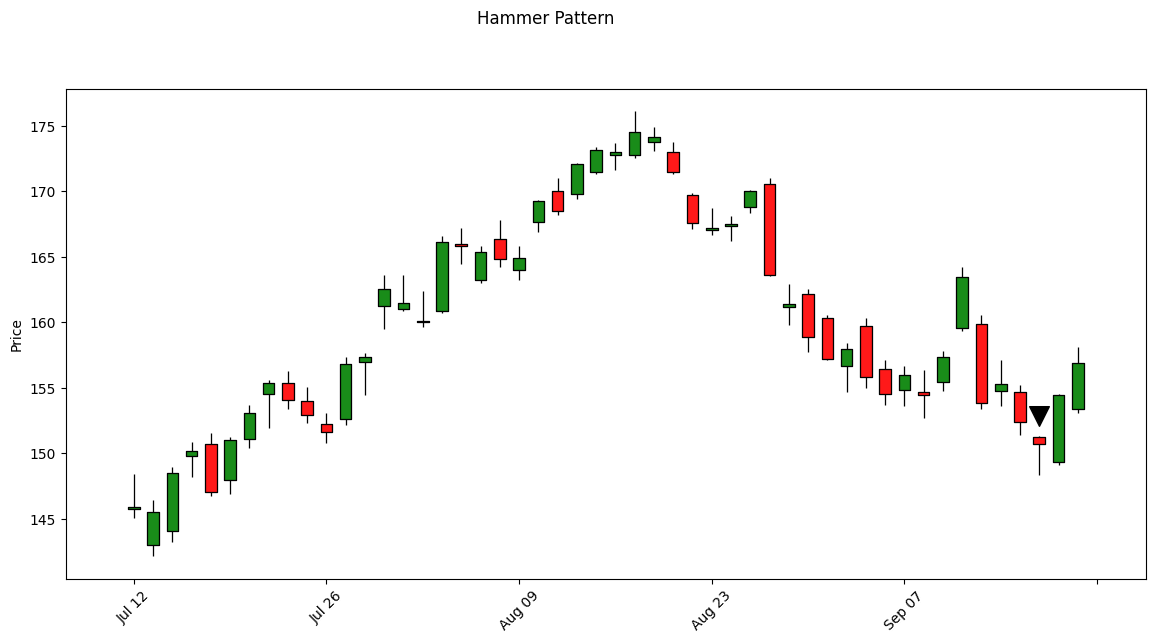

In [4]:
# Set pattern occurrence positions 
hammer_marker = np.where(data.tail(50).pattern_signal == 100, (1.01 * data.tail(50).High), np.nan)

# Plot hammer pattern 
hammer_plot = mpf.make_addplot(hammer_marker, type='scatter', marker='v', markersize=200, panel=0, color="black")
mpf.plot(data.tail(50), type='candle', style=mpf.make_mpf_style(marketcolors=mpf.make_marketcolors(up='g',down='r')),
         addplot=hammer_plot, title='Hammer Pattern', figsize=(15, 7))

We found one red hammer pattern towards the right end of the chart.

<a id='entry'></a>
## Entry Condition

We will check the conditions for entering the trade, set the `entry_signal` as `1` when `pattern_signal` is 100 . `1` indicates that we will initiate a long position. 

Entry: We will enter the trade at the `Open` of the current candle if the previous candle is a hammer and there is an existing downtrend. We will check for the downtrend by checking the `Close` prices of the previous 3 candles. If the `Close` prices of the last 3 candles are in ascending order, i.e. if the `Close` price of the candle just previous to the hammer is less than its previous candle and so on then it can be considered as a downtrend.

In [5]:
# Check if pattern is formed
condition_1 = (data['pattern_signal'] == 100)

# Check if there is a downtrend
condition_2 = data.Close.shift(1) < data.Close.shift(2)
condition_3 = data.Close.shift(2) < data.Close.shift(3)
condition_4 = data.Close.shift(3) < data.Close.shift(4)

# Generate entry signal
data['entry_signal'] = np.where(condition_1 & condition_2 & condition_3 & condition_4, 1, 0)

<a id='exit'></a>
## Exit Condition

Stop-loss: The stop-loss will be kept at the `Low` price of the hammer. In the below example, the entry price is 50 and the `Low` price of the hammer candle is 30, so we will keep the stop-loss at 30. 

Take-profit: It has been observed that the hammer pattern has less number of winning trades as compared to losing trades. But the profits in case of winning trades are high. So in our strategy we will book the profit if the price moves up by 3 times of the difference between stop-loss and entry price. We will call this as `rr` which is basically reward to risk ratio. In the below example, as the difference between the entry price and stop-loss is 20 points so we will keep the take-profit at 110.

![title](https://d2a032ejo53cab.cloudfront.net/Course/Units/Mcq/UnitContent/xpfmWd6k/hammerentryexit.png)

The stop-loss and take-profit will be calculated using `exit_values` function which has been explained in detail in the previous notebooks.

<a id='backtesting_and_performance'></a>
## Backtesting and Strategy Performance

We will use the `backtesting` function from `candlestick_quantra_utility` to backtest our trading strategy. It takes dataframe `data`, trade direction which can be `long` or `short`, `rr` which is basically reward to risk ratio as inputs, backtests the trading strategy and returns `trades` which is basically the trade sheet, and dataframe `data` which contains the trading signals.

For checking the strategy performance we will use two functions, `trade_level_analytics` for calculating trade level analytics and `performance_metrics` for checking the strategy performance. The codes for these functions have been taken directly from the previous notebooks.

In [6]:
# Backtest the strategy and generate trade sheet
data, trades = backtesting(data, direction = "long", rr = 3)
trades.tail()

------------------------------
Trade No: 1 | Entry Date: 2014-05-12 00:00:00 | Entry Price: 20.981787
Trade No: 1 | Exit Type: TP | Date: 2014-05-23 00:00:00 | Exit Price: 21.933214 | PnL: 0.95 | Cum PnL: 0.95
------------------------------
Trade No: 2 | Entry Date: 2014-08-11 00:00:00 | Entry Price: 23.817499
Trade No: 2 | Exit Type: TP | Date: 2014-08-22 00:00:00 | Exit Price: 25.33 | PnL: 1.51 | Cum PnL: 2.46
------------------------------
Trade No: 3 | Entry Date: 2016-06-03 00:00:00 | Entry Price: 24.4475
Trade No: 3 | Exit Type: SL | Date: 2016-06-17 00:00:00 | Exit Price: 23.8325 | PnL: -0.62 | Cum PnL: 1.84
------------------------------
Trade No: 4 | Entry Date: 2016-10-24 00:00:00 | Entry Price: 29.275
Trade No: 4 | Exit Type: SL | Date: 2016-10-26 00:00:00 | Exit Price: 28.897499 | PnL: -0.38 | Cum PnL: 1.46
------------------------------
Trade No: 5 | Entry Date: 2020-03-24 00:00:00 | Entry Price: 59.09
Trade No: 5 | Exit Type: TP | Date: 2020-05-08 00:00:00 | Exit Price: 7

,Entry_Date,Entry_Price,Exit_Date,Exit_Type,Exit_Price,PnL
2,2016-06-03,24.447500,2016-06-17,SL,23.832500,-0.62
3,2016-10-24,29.275000,2016-10-26,SL,28.897499,-0.38
4,2020-03-24,59.090000,2020-05-08,TP,77.532501,18.44
5,2021-10-14,142.110001,2021-10-28,TP,152.570007,10.46
6,2022-04-26,162.250000,2022-04-27,SL,156.570007,-5.68


In [7]:
# Trade Level Analytics
analytics = trade_level_analytics(trades)
analytics.T

Total PnL:  24.680000000000003


,Strategy
Total PnL,24.68
total_trades,7
Number of Winners,4
Number of Losers,3
Win (%),57.142857
Loss (%),42.857143
per_trade_PnL_winners,7.84
per_trade_PnL_losers,2.226667
Average holding time,14 days 00:00:00
Profit Factor,4.694611


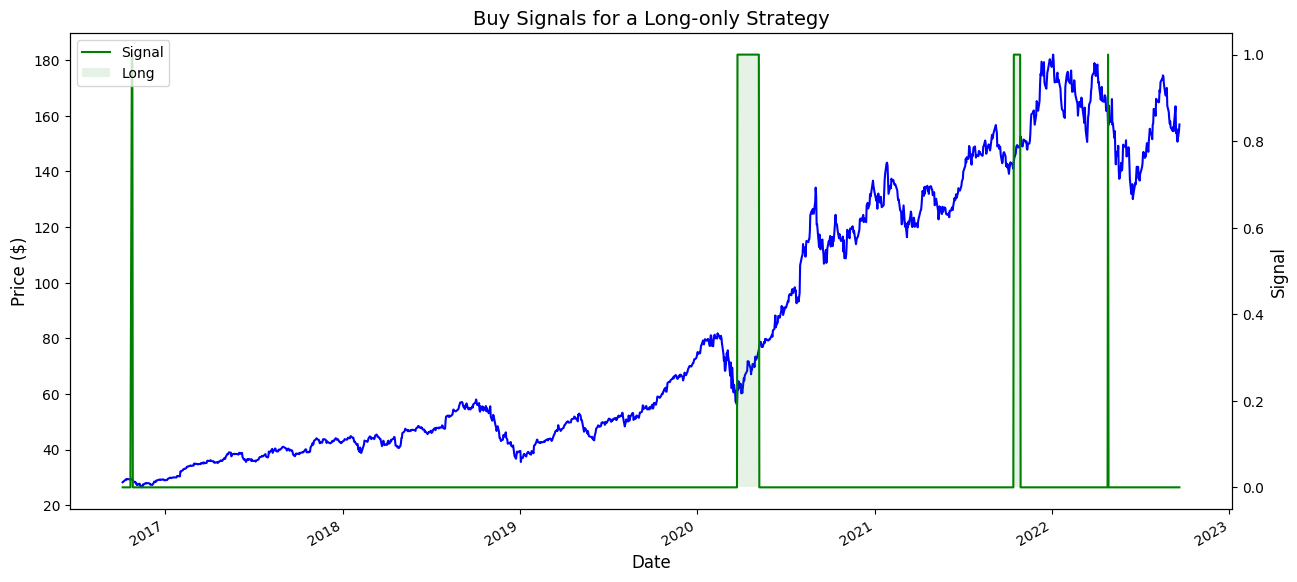

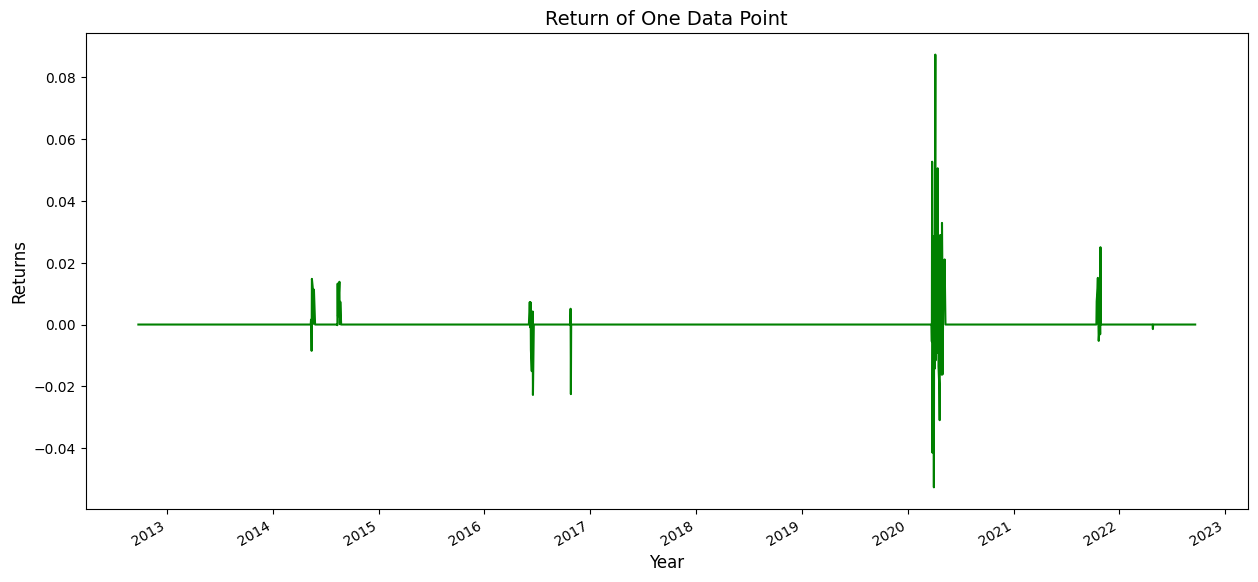

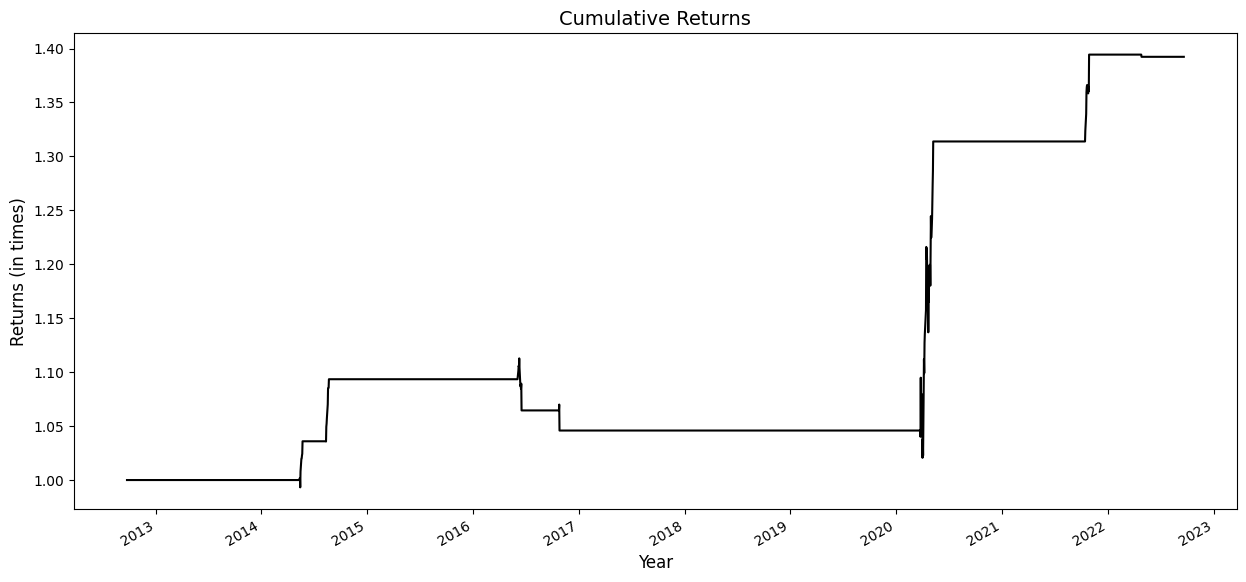

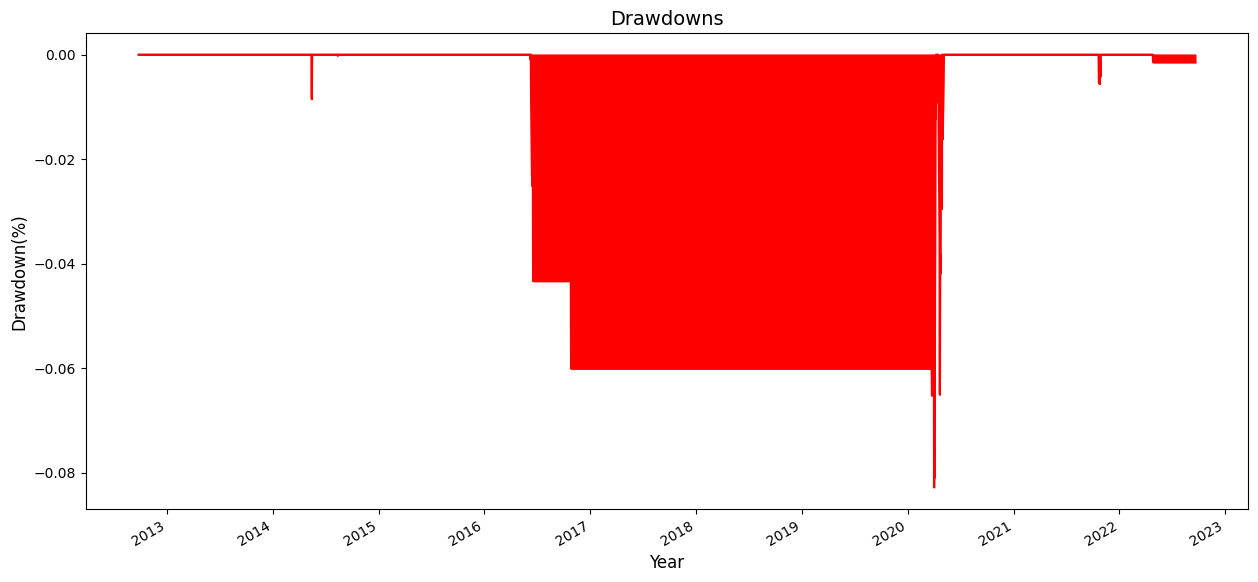

,Strategy
Sharpe Ratio,1.652711
Maximum Drawdown,-8.28%


In [8]:
# Performance metrics
performance_metrics = performance_metrics(data, direction = "long")
performance_metrics.T

## Conclusion

In this notebook, we saw how we can trade a hammer pattern with a defined stop-loss and take-profit level. We also analysed the performance of our trading strategy so as to get a deeper idea about the strategy performance. You can also try to backtest a trading strategy for hammer patterns with different sets of entry and exit conditions. 

In the next section, we will look at another candlestick pattern, a hanging man pattern.<br><br>